<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Solutions_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 1.

In [2]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import metrics

from matplotlib import  pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import os
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [3]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

262789/262789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
pip install dtreeviz==1.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 1.5 MB/s eta 0:00:00


In [5]:
from dtreeviz.trees import dtreeviz # remember to load the package

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [6]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [5.55514566] ;  b = -0.6198254153283074


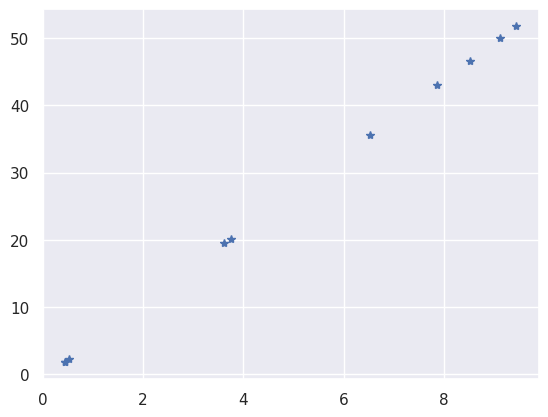

In [7]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

true slopes: w = [6.60520906 3.97713837] ;  b = 2.6990239460961547


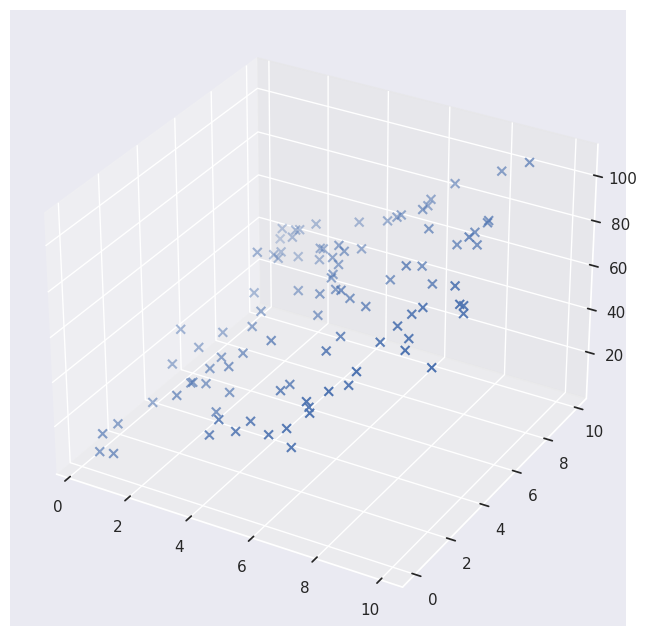

In [8]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [9]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [10]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


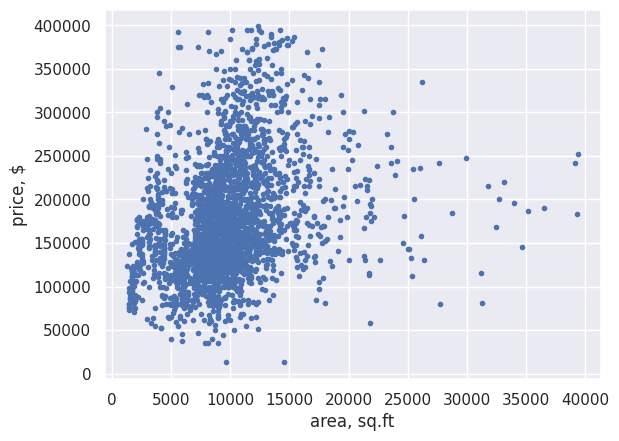

In [11]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

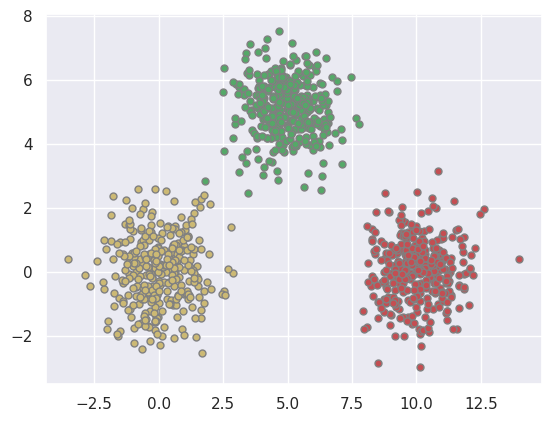

In [12]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [13]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's check few samples:

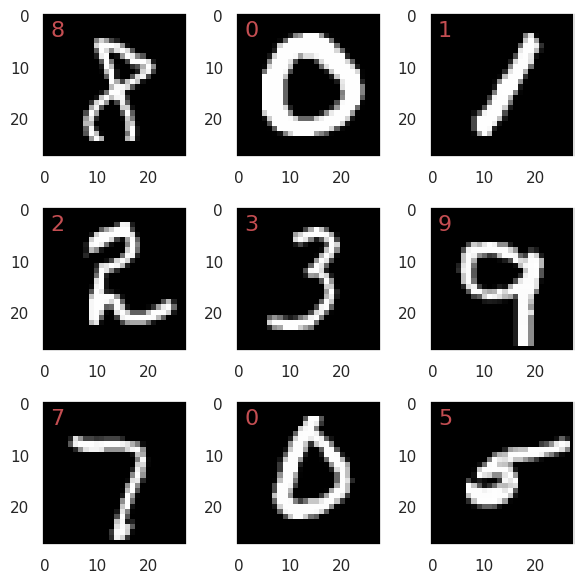

In [14]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()


## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's check few samples:

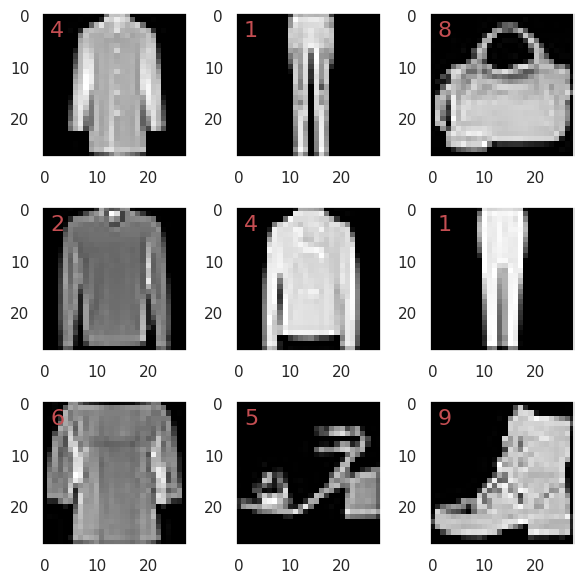

In [16]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()

In [17]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# EXERCISE 1.

train rmse = 26429.635
test rmse = 24762.021
train mae = 18500.342
test mae = 17440.111
train R2 = 0.8403030037879944
test R2 = 0.8560634255409241


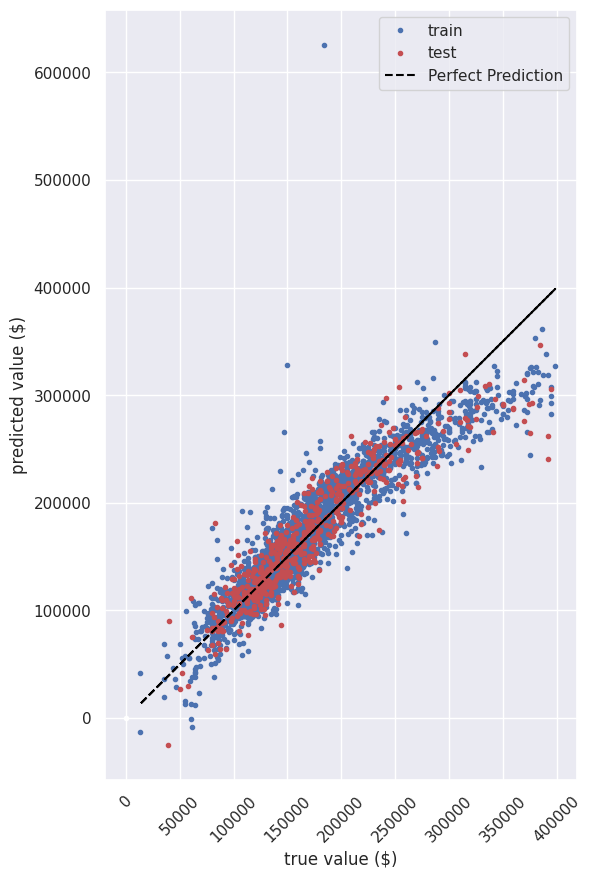

In [18]:
# Solution:
x, y = house_prices_dataset()

# 1. make train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train = reg.predict(x_train)
y_p_test = reg.predict(x_test)

residuals_train = y_train - y_p_train
residuals_test = y_test - y_p_test

# mse
print('train rmse =', np.sqrt( np.mean(residuals_train**2)   ) )
print('test rmse =', np.sqrt( np.mean(residuals_test**2)   ) )
# mse
print('train mae =', np.mean(np.abs(residuals_train)))
print('test mae =', np.mean(np.abs(residuals_test)))
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black', label='Perfect Prediction')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true value ($)')
plt.ylabel('predicted value ($)')
_ = plt.xticks(rotation=45)
plt.gca().set_aspect('equal')
plt.legend()


# EXERCISE 2.

In [1]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

NameError: name 'tf' is not defined

We will reshape 2-d images to 1-d arrays for use in scikit-learn:

In [19]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [20]:
import numpy as np

def extract_features(images):
    def compute_power_spectrum(image):
        fourier_transform = np.fft.fft2(image)
        power_spectrum = np.abs(fourier_transform) ** 2
        power_spectrum /= np.sum(power_spectrum)
        return power_spectrum.flatten()
    power_spectrum_features = []
    for img in images:
        spectrum = compute_power_spectrum(img)
        power_spectrum_features.append(spectrum)
    return np.array(power_spectrum_features)

train_features = extract_features(train_images_norm)
test_features = extract_features(test_images_norm)


Now use a multinomial logistic regression classifier, and measure the accuracy:

In [21]:
#solution
# 1. Create classifier
multi_class = 'multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=20,
                                      multi_class=multi_class)

# 2. fit the model
t1 = timer()
clf.fit(train_features, train_labels)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(train_features, train_labels)))
print("test score : %.3f" % (clf.score(test_features, test_labels)))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


training time: 38.8s
training score : 0.674
test score : 0.668


Now we evaluate the confusion matrix, inspect it and print the per class precision and recall:

[[680  11  82  95  37  15  59   3  11   7]
 [ 29 813  14 132   3   0   7   0   2   0]
 [ 71   1 706   9 118   6  76   0   8   5]
 [163  55  11 738  12   3  14   0   3   1]
 [167   3 366  72 295  18  65   0  11   3]
 [  3   1   3   1   0 795   2 130  12  53]
 [246   2 309  50 155  13 188   0  30   7]
 [  0   0   0   0   0  38   0 864  17  81]
 [  5   2  82  10   9  27   6  18 774  67]
 [ 41   0   4   8   4  16  13  67  24 823]]
Check that you get the same accuracy from the score method: 0.6676


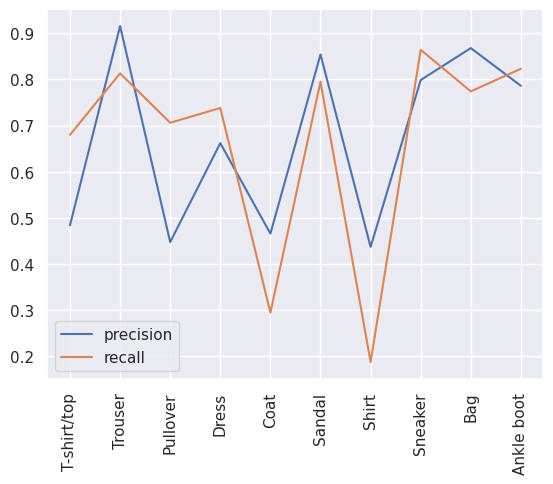

In [22]:
test_labels_pred = clf.predict(test_features)

from sklearn import metrics
cm=metrics.confusion_matrix( test_labels, test_labels_pred )
print(cm)

print(f'Check that you get the same accuracy from the score method: {np.sum([cm[i,i] for i in range(10)])/np.sum(cm)}')

def get_class_specific_prec_recall(cm):
    n_cat=cm.shape[0]
    precisions=[]
    recalls=[]
    #precision
    for i in range(n_cat):
        precisions.append(cm[i,i]/np.sum(cm[:,i]))

    #recall
    for i in range(n_cat):
        recalls.append(cm[i,i]/np.sum(cm[i,:]))
    return precisions, recalls

precisions, recalls = get_class_specific_prec_recall(cm)

plt.plot(fmnist_class_names,precisions, label='precision')
plt.plot(fmnist_class_names,recalls, label='recall')
plt.xticks(rotation=90)
plt.legend()

plt.show()

# EXERCISE 3 : Random forest classifier for FMNIST

In [37]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

import numpy as np

def extract_features(images):
    def compute_power_spectrum(image):
        fourier_transform = np.fft.fft2(image)
        power_spectrum = np.abs(fourier_transform) ** 2
        power_spectrum /= np.sum(power_spectrum)
        return power_spectrum.flatten()
    power_spectrum_features = []
    for img in images:
        spectrum = compute_power_spectrum(img)
        power_spectrum_features.append(spectrum)
    return np.array(power_spectrum_features)

train_features = extract_features(train_images_norm)
test_features = extract_features(test_images_norm)


In [38]:
#solution
# 1. Create classifier
clf = ensemble.RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1)

# 2. fit the model
t1 = timer()
clf.fit(train_features, train_labels)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(train_features, train_labels)))
print("test score : %.3f" % (clf.score(test_features, test_labels)))

training time: 66.2s
training score : 0.848
test score : 0.789


[[729   4  54 111  19  23  30   0  22   8]
 [  5 906   7  68   7   1   3   0   3   0]
 [ 28   0 673  18 165   7  80   0  28   1]
 [ 45   7  11 878  23   2  27   0   6   1]
 [ 31   0 108  89 673   7  78   0  14   0]
 [  2   0   0   0   0 913   0  59   2  24]
 [206   0 143 100 103  15 374   0  55   4]
 [  0   0   0   0   0  36   0 898   1  65]
 [  6   0  20   3   8  25   9   5 917   7]
 [  4   0   1   4   0  23   0  30   1 937]]
Check that you get the same accuracy from the score method: 0.7898


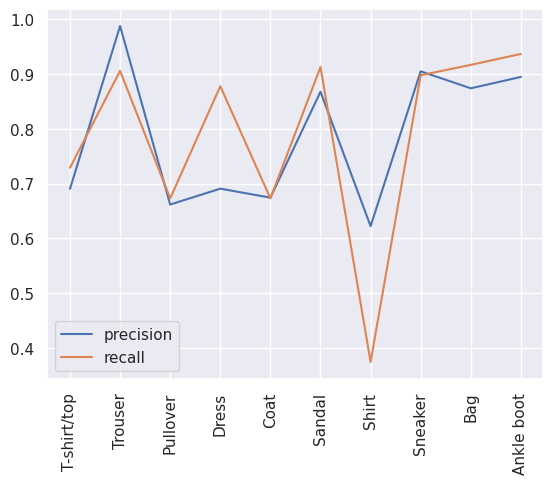

In [25]:
test_labels_pred = clf.predict(test_features)

from sklearn import metrics
cm=metrics.confusion_matrix( test_labels, test_labels_pred )
print(cm)

print(f'Check that you get the same accuracy from the score method: {np.sum([cm[i,i] for i in range(10)])/np.sum(cm)}')

def get_class_specific_prec_recall(cm):
    n_cat=cm.shape[0]
    precisions=[]
    recalls=[]
    #precision
    for i in range(n_cat):
        precisions.append(cm[i,i]/np.sum(cm[:,i]))

    #recall
    for i in range(n_cat):
        recalls.append(cm[i,i]/np.sum(cm[i,:]))
    return precisions, recalls

precisions, recalls = get_class_specific_prec_recall(cm)

plt.plot(fmnist_class_names,precisions, label='precision')
plt.plot(fmnist_class_names,recalls, label='recall')
plt.xticks(rotation=90)
plt.legend()

plt.show()

## EX 3 ADDITIONAL MATERIAL: feature importance

In [26]:
p_importances = permutation_importance(clf, test_features, test_labels, n_repeats=10, n_jobs=-1) #NB: expensive on Colab
rf_importances = clf.feature_importances_

In [27]:
def plot_importances(p_importances, label):
    fig,ax=plt.subplots(1,2,figsize=(19,5))
    y=np.abs(p_importances)
    y=y/np.sum(y)
    ax[0].plot(y)
    ax[0].set_xlabel('Feature index')
    ax[0].set_ylabel(label)
    mod_freq=[]
    for fx in np.fft.fftfreq(28):
        for fy in np.fft.fftfreq(28):
            mod_freq.append(np.sqrt(fx**2+fy**2))
    mod_freq=np.array(mod_freq)
    sorted_indices = np.argsort(mod_freq)
    x = mod_freq[sorted_indices]
    ax[1].plot(x, y[sorted_indices],'-o', markersize=2)
    ax[1].set_xlabel('Wavelength modulus')
    ax[1].set_ylabel(label)
    return fig

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - permutation feature importance')

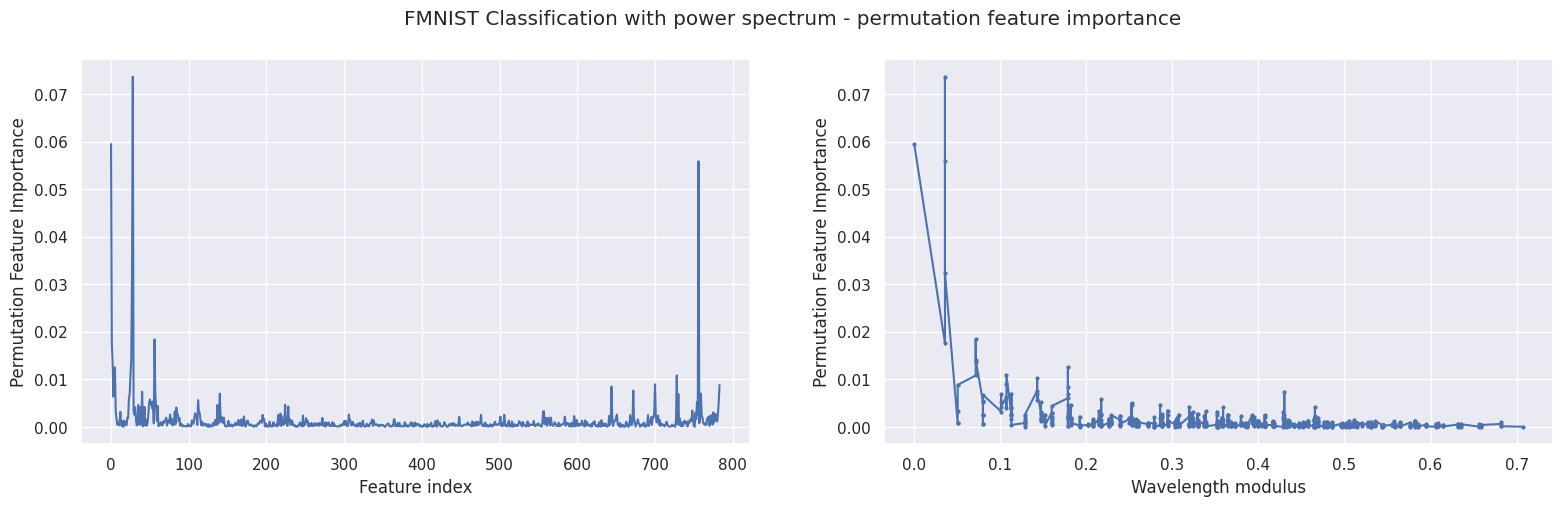

In [28]:
fig=plot_importances(p_importances['importances_mean'], label='Permutation Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - permutation feature importance')

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - Tree-based feature importance')

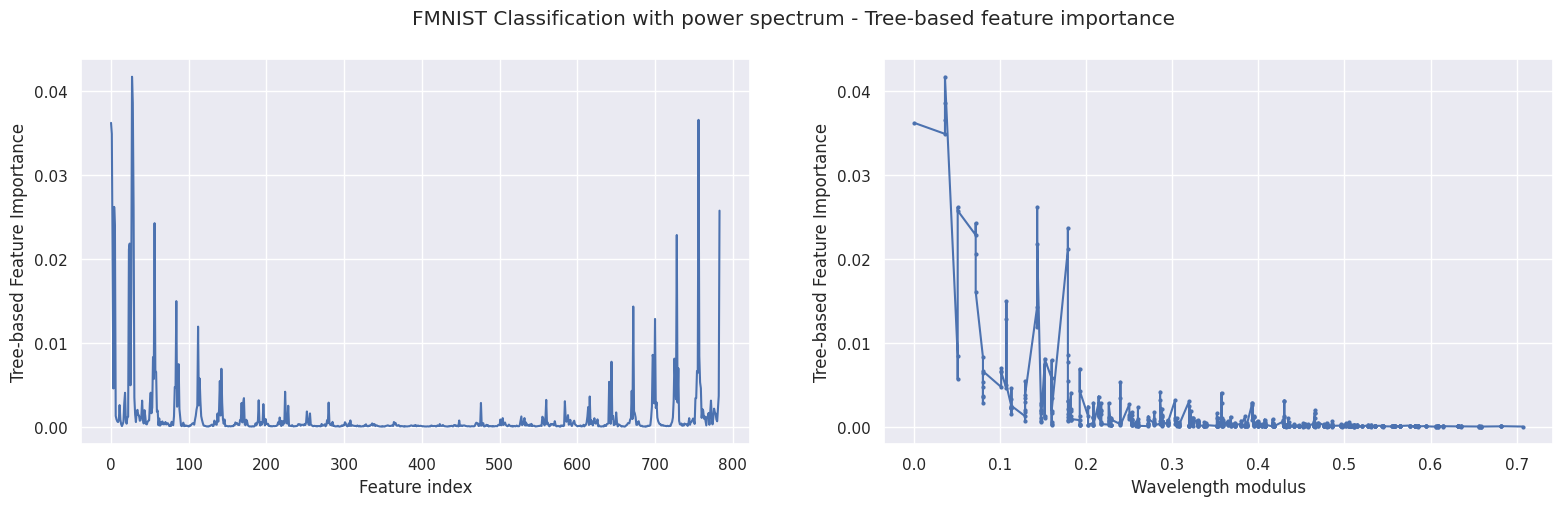

In [29]:
fig=plot_importances(rf_importances, label='Tree-based Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - Tree-based feature importance')

1.0000000000000002


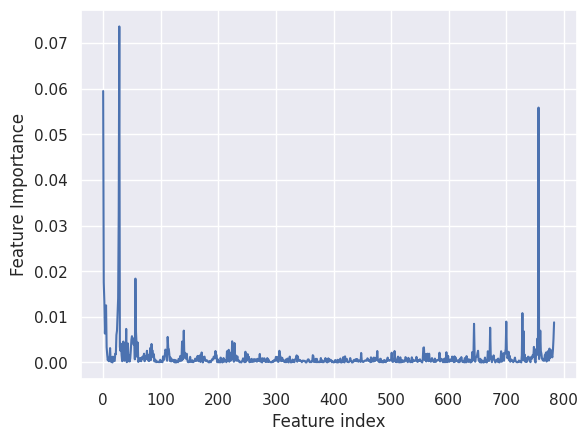

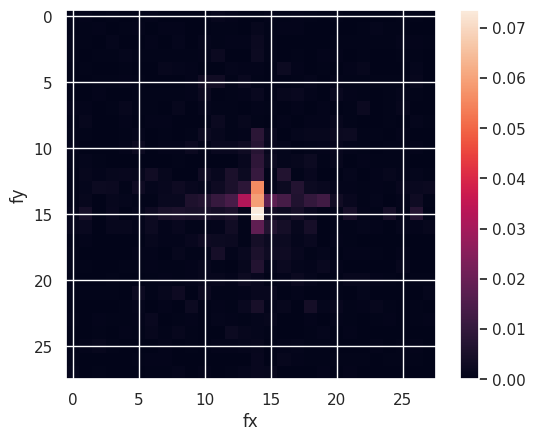

In [30]:
# 2-D visualization of the Feature Importance

p_importances_reshaped=np.abs(p_importances['importances_mean']).reshape(28,28)
p_importances_reshaped=p_importances_reshaped/np.sum(p_importances_reshaped)
print(np.sum(p_importances_reshaped))
plt.plot(p_importances_reshaped.flatten())
plt.xlabel('Feature index')
plt.ylabel('Feature Importance')
plt.figure()
p_importances_reshaped=np.fft.fftshift(p_importances_reshaped)
plt.imshow(p_importances_reshaped)
plt.xlabel('fx')
plt.ylabel('fy')
plt.colorbar()


## EXERCISE 4: Random forest/XGboost regression

### Random Forest

In [31]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Predict the house prices.

In [32]:
rfr = ensemble.RandomForestRegressor(max_depth=5, n_estimators=30)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8564095902329769

In [33]:
rfr = ensemble.RandomForestRegressor(max_depth=30, n_estimators=70)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8958942904832323

[]

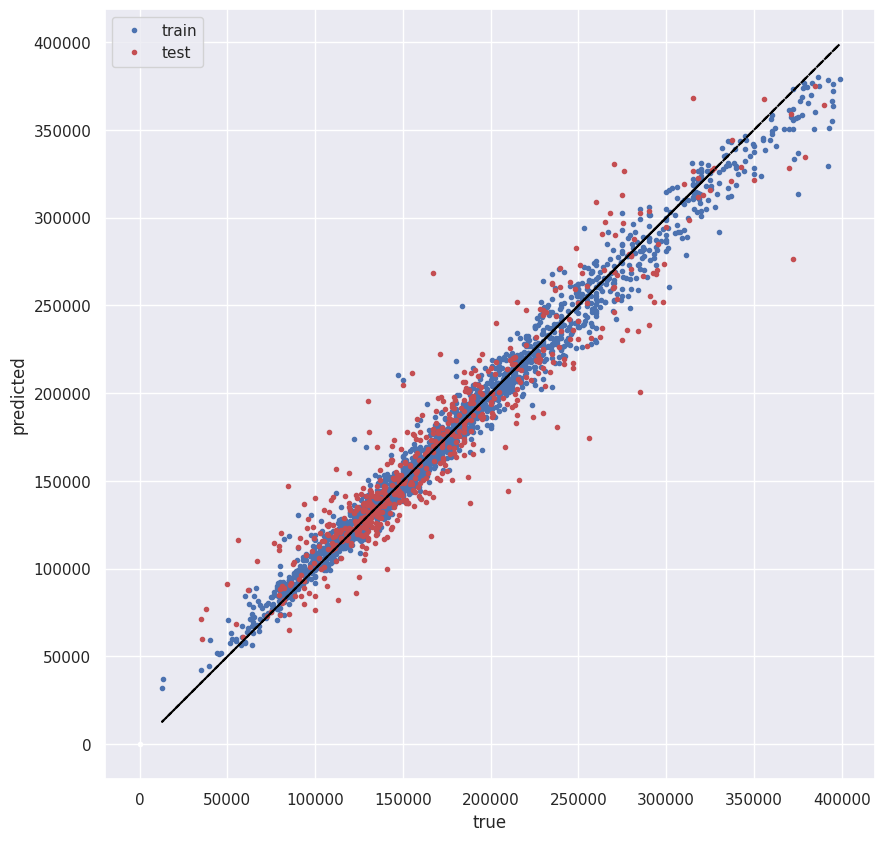

In [34]:
y_p_train = rfr.predict(x_train)
y_p_test = rfr.predict(x_test)


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

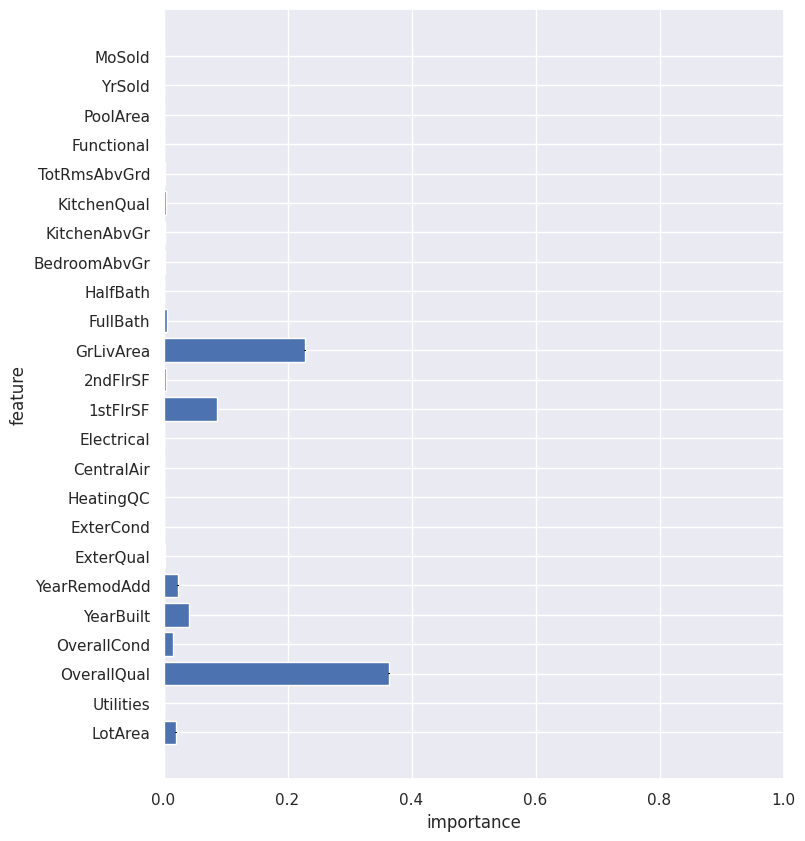

In [35]:
p_importances = permutation_importance(rfr, x_test, y_test, n_repeats=10, n_jobs=-1)

def plot_importances(feature_names, permutation_importances):
        plt.figure(figsize=(8, 10))
        plt.barh(feature_names,
                permutation_importances.importances_mean,
                yerr=permutation_importances.importances_std, )
        plt.ylabel('feature')
        plt.xlabel('importance')
        plt.xlim(0, 1)
        return

plot_importances(list(df_x.columns), p_importances)

### XGBoost

In [36]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x, y = house_prices_dataset()

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create an XGBoost regression model
model = XGBRegressor(eval_metric='rmse' ,max_depth= 5, learning_rate=0.3, n_estimators=100 )

# Train the XGBoost regression model
model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=True)

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)


TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
from sklearn.metrics import r2_score

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', r2_score(y_train, y_p_train))
print('test R2 =', r2_score(y_test, y_p_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot(y_train, y_train,'-')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

In [ ]:
p_importances = permutation_importance(model, x_test, y_test, n_repeats=10, n_jobs=-1)

plt.figure(figsize=(8, 10))
plt.barh(list(df_x.columns),
        p_importances.importances_mean,
        yerr=p_importances.importances_std, )
plt.ylabel('feature')
plt.xlabel('importance')
plt.xlim(0, 1);